In [19]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics.cluster import adjusted_rand_score, silhouette_score
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.manifold import MDS
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import StandardScaler

In [4]:
df = pd.read_csv("./train.csv")
df_s = df.sort(['Device'])

/usr/local/lib/python3.5/dist-packages/ipykernel/__main__.py:2: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  from ipykernel import kernelapp as app


In [5]:
def process_df(df):
    # get new datetime
    df['time'] = pd.to_datetime(df['T'])
    # get second level as new column
    timestamp = pd.DatetimeIndex(df['time'])
    df['second'] = timestamp.to_period('s')
    df['X_absdif'] = df['X'].diff().abs()
    df['Y_absdif'] = df['Y'].diff().abs()
    df['Z_absdif'] = df['Z'].diff().abs()
    df_dif = df.groupby(['Device','second'])[['X_absdif', 'Y_absdif', 'Z_absdif']].sum().reset_index()
    df_avg = df.groupby(['Device', 'second'])[['X', 'Y', 'Z']].mean().add_suffix('_avg').reset_index()
    df_new = pd.concat([df_dif, df_avg], axis=1)
    return df_new

In [6]:
df_new = process_df(df_s)

In [7]:
df_new.shape

(585, 10)

In [8]:
df_new.to_csv("processed.csv")

In [9]:
df_new.head()

,Device,second,X_absdif,Y_absdif,Z_absdif,Device,second,X_avg,Y_avg,Z_avg
0,7,1970-01-01 00:22:16,3687.395881,3283.974781,3986.811943,7,1970-01-01 00:22:16,0.455959,7.410139,4.665212
1,7,1970-01-01 00:22:17,60788.388180,63687.793178,74924.008647,7,1970-01-01 00:22:17,0.907226,6.072896,4.970928
2,7,1970-01-01 00:22:18,53778.390286,55347.904005,68945.819412,7,1970-01-01 00:22:18,0.741240,5.810950,3.037089
3,7,1970-01-01 00:22:19,31594.494071,33003.001559,36655.679592,7,1970-01-01 00:22:19,0.832763,5.926073,5.437882
4,7,1970-01-01 00:22:20,35671.622622,35390.811626,39105.080966,7,1970-01-01 00:22:20,1.004834,5.853294,3.865663


In [27]:
cols=pd.Series(df_new.columns)
for dup in df_new.columns.get_duplicates(): cols[df_new.columns.get_loc(dup)]=[dup+'.'+str(d_idx) if d_idx!=0 else dup for d_idx in range(df_new.columns.get_loc(dup).sum())]
df_new.columns=cols

In [80]:
df_new.head()

,Unnamed: 0,Device,second,X_absdif,Y_absdif,Z_absdif,Device.1,second.1,X_avg,Y_avg,Z_avg,labels
0,0,7,1970-01-01 00:22:16,3687.395881,3283.974781,3986.811943,7,1970-01-01 00:22:16,0.455959,7.410139,4.665212,1
1,1,7,1970-01-01 00:22:17,60788.388180,63687.793178,74924.008647,7,1970-01-01 00:22:17,0.907226,6.072896,4.970928,1
2,2,7,1970-01-01 00:22:18,53778.390286,55347.904005,68945.819412,7,1970-01-01 00:22:18,0.741240,5.810950,3.037089,1
3,3,7,1970-01-01 00:22:19,31594.494071,33003.001559,36655.679592,7,1970-01-01 00:22:19,0.832763,5.926073,5.437882,1
4,4,7,1970-01-01 00:22:20,35671.622622,35390.811626,39105.080966,7,1970-01-01 00:22:20,1.004834,5.853294,3.865663,1


### clustering

In [81]:
df_new = pd.read_csv("processed.csv")

In [82]:
df_new.head()

,Unnamed: 0,Device,second,X_absdif,Y_absdif,Z_absdif,Device.1,second.1,X_avg,Y_avg,Z_avg
0,0,7,1970-01-01 00:22:16,3687.395881,3283.974781,3986.811943,7,1970-01-01 00:22:16,0.455959,7.410139,4.665212
1,1,7,1970-01-01 00:22:17,60788.388180,63687.793178,74924.008647,7,1970-01-01 00:22:17,0.907226,6.072896,4.970928
2,2,7,1970-01-01 00:22:18,53778.390286,55347.904005,68945.819412,7,1970-01-01 00:22:18,0.741240,5.810950,3.037089
3,3,7,1970-01-01 00:22:19,31594.494071,33003.001559,36655.679592,7,1970-01-01 00:22:19,0.832763,5.926073,5.437882
4,4,7,1970-01-01 00:22:20,35671.622622,35390.811626,39105.080966,7,1970-01-01 00:22:20,1.004834,5.853294,3.865663


In [6]:
len(df_new['Device'].unique())

387

In [24]:
predictors = ["X_avg", "Y_avg", "Z_avg", "X_absdif", "Y_absdif", "Z_absdif"]
X_train = df_new[predictors]
km = KMeans(n_clusters=2, random_state=0)
km.fit(X_train)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=2, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=0, tol=0.0001, verbose=0)

In [25]:

km_predicted = km.predict(X_train)

In [26]:
labels = list(df_new['Device'])

In [27]:
adjusted_rand_score(labels, km_predicted)

-2.6354649221338092e-05

In [12]:
from sklearn.metrics import silhouette_samples

def silhouette_plot(X, cluster_labels, ax=None):
    silhouette_scores = silhouette_samples(X, cluster_labels)
    if ax is None:
        ax = plt.gca()
    y_lower = 10
    inliers = cluster_labels != -1
    X = X[inliers]
    cluster_labels = cluster_labels[inliers]
    silhouette_scores = silhouette_scores[inliers]
    labels = np.unique(cluster_labels)
    cm = plt.cm.Vega10 if len(labels) <= 10 else plt.cm.Vega20
    #cm = plt.cm.Vega20
    for i in labels:
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            silhouette_scores[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm(i)
        ax.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

In [14]:
X_scaled

StandardScaler(copy=True, with_mean=True, with_std=True)

In [17]:
predic_map = {"X_avg":0, "Y_avg":1, "Z_avg":2, "X_absdif":3, "Y_absdif":4, "Z_absdif":5}

In [30]:
int_predict_map={0:"X_avg", 1:"Y_avg", 2:"Z_avg", 3:"X_absdif", 4:"Y_absdif", 5:"Z_absdif"}

/home/yh2901/.local/lib/python3.5/site-packages/matplotlib/__init__.py:1405: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


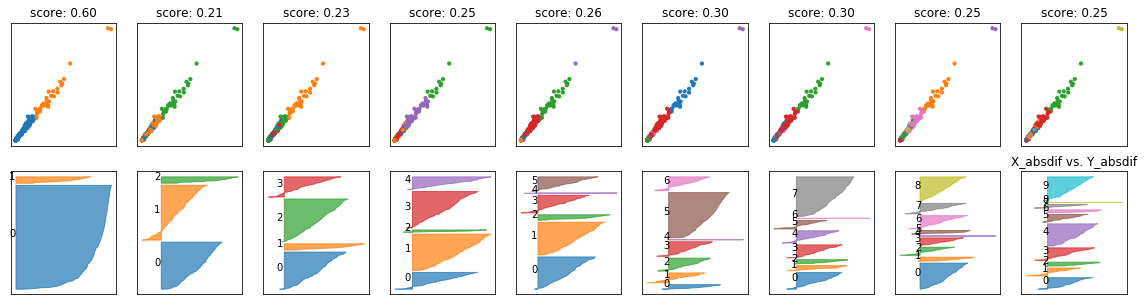

In [22]:
# scale data
s = StandardScaler()
X_scaled = s.fit_transform(X_train)

%matplotlib inline
import matplotlib
matplotlib.use('TkAgg')
import matplotlib.pyplot as plt
fig, axes = plt.subplots(2, 9, subplot_kw={'xticks': (), 'yticks':()}, figsize=(20, 5))
plt.title("X_absdif vs. Y_absdif", loc='center')
for ax, n_clusters in zip(axes.T, [2, 3, 4, 5, 6, 7, 8, 9, 10]):
    X = X_scaled
    km = KMeans(n_clusters=n_clusters)
    km.fit(X)
    ax[0].scatter(X[:,predic_map['X_absdif']], X[:,predic_map['Y_absdif']],c=plt.cm.Vega10(km.labels_), s=10) #'activity_count','averaged_scores'
    silhouette_plot(X, km.labels_, ax=ax[1])
    ax[0].set_title("score: {:.2f}".format(silhouette_score(X, km.labels_)))

/home/yh2901/.local/lib/python3.5/site-packages/matplotlib/__init__.py:1405: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


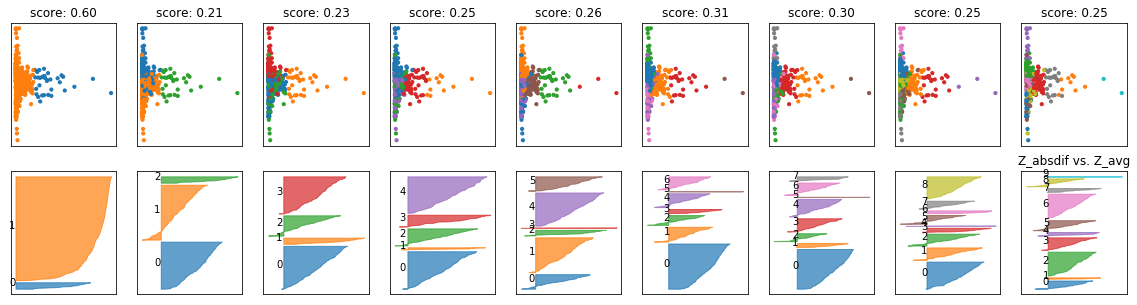

In [40]:
# scale data
s = StandardScaler()
X_scaled = s.fit_transform(X_train)

%matplotlib inline
import matplotlib
matplotlib.use('TkAgg')
import matplotlib.pyplot as plt
fig, axes = plt.subplots(2, 9, subplot_kw={'xticks': (), 'yticks':()}, figsize=(20, 5))
plt.title("Z_absdif vs. Z_avg", loc='center')
for ax, n_clusters in zip(axes.T, [2, 3, 4, 5, 6, 7, 8, 9, 10]):
    X = X_scaled
    km = KMeans(n_clusters=n_clusters)
    km.fit(X)
    ax[0].scatter(X[:,predic_map['Z_absdif']], X[:,predic_map['Z_avg']],c=plt.cm.Vega10(km.labels_), s=10) #'activity_count','averaged_scores'
    silhouette_plot(X, km.labels_, ax=ax[1])
    ax[0].set_title("score: {:.2f}".format(silhouette_score(X, km.labels_)))

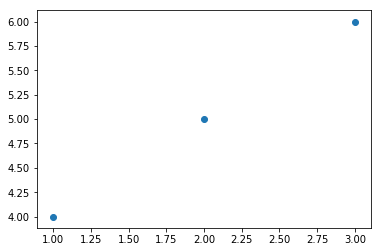

In [64]:
a = [1,2,3]
b = [4,5,6]
plt.scatter(a,b)

In [65]:
import warnings

def fxn():
    warnings.warn("deprecated", DeprecationWarning)

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    fxn()

In [67]:
import warnings
warnings.filterwarnings("ignore")

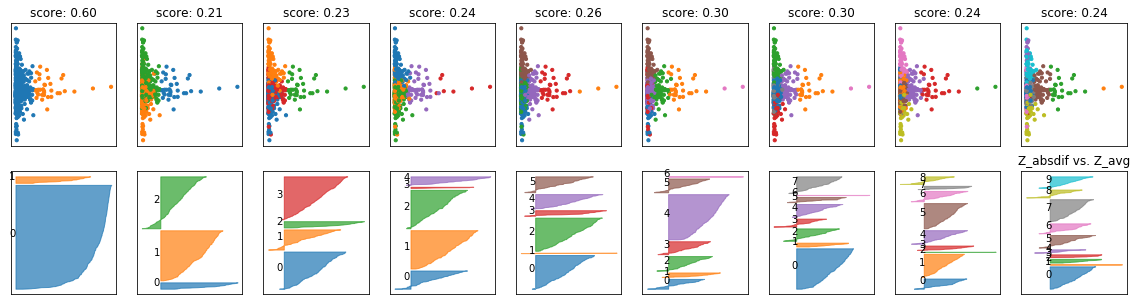

In [68]:
# scale data
s = StandardScaler()
X_scaled = s.fit_transform(X_train)

%matplotlib inline
import matplotlib
matplotlib.use('TkAgg')
import matplotlib.pyplot as plt
fig, axes = plt.subplots(2, 9, subplot_kw={'xticks': (), 'yticks':()}, figsize=(20, 5))
plt.title("Z_absdif vs. Z_avg", loc='center')
for ax, n_clusters in zip(axes.T, [2, 3, 4, 5, 6, 7, 8, 9, 10]):
    X = X_scaled
    km = KMeans(n_clusters=n_clusters)
    km.fit(X)
    ax[0].scatter(X[:,predic_map['Z_absdif']], X[:,predic_map['X_avg']],c=plt.cm.Vega10(km.labels_), s=10) #'activity_count','averaged_scores'
    silhouette_plot(X, km.labels_, ax=ax[1])
    ax[0].set_title("score: {:.2f}".format(silhouette_score(X, km.labels_)))

### centroid center

In [54]:
predictors = ["X_avg", "Y_avg", "Z_avg", "X_absdif", "Y_absdif", "Z_absdif"]
X_train = df_new[predictors]
s = StandardScaler()
X_scaled = s.fit_transform(X_train)
km = KMeans(n_clusters=2, random_state=0)
km.fit(X_scaled)
km_predicted = km.predict(X_scaled)

In [55]:
centroids = km.cluster_centers_

k = 2
for i in range(k):
    print ("\ncluster " + str(i))
    for j in range(len(centroids[i])):
        print (int_predict_map[j], centroids[i][j])


cluster 0
X_avg 0.136169661507
Y_avg -0.210280809267
Z_avg -0.105182184924
X_absdif 3.20219695185
Y_absdif 3.20059614029
Z_absdif 3.18194324775

cluster 1
X_avg -0.00866534209588
Y_avg 0.0133815060443
Z_avg 0.00669341176789
X_absdif -0.203776169663
Y_absdif -0.203674299837
Z_absdif -0.202487297584


small class

In [56]:
len([i for i in km_predicted if i == 1])

550

In [57]:
len([i for i in km_predicted if i == 0])

35

In [58]:
len(km_predicted)

585

In [70]:
predictors

['X_avg', 'Y_avg', 'Z_avg', 'X_absdif', 'Y_absdif', 'Z_absdif']

### append label back to dataframe

In [71]:
df_new.shape

(585, 11)

In [72]:
df_new.columns

Index(['Unnamed: 0', 'Device', 'second', 'X_absdif', 'Y_absdif', 'Z_absdif',
       'Device.1', 'second.1', 'X_avg', 'Y_avg', 'Z_avg'],
      dtype='object')

In [77]:
predictors = ["X_avg", "Y_avg", "Z_avg", "X_absdif", "Y_absdif", "Z_absdif"]
X_train = df_new[predictors]
s = StandardScaler()
X_scaled = s.fit_transform(X_train)
km = KMeans(n_clusters=2, random_state=0)
km.fit(X_scaled)
km_predicted = km.predict(X_scaled)
km.labels_.shape

(585,)

In [83]:
df_new['labels'] = km.labels_

In [84]:
df_new.head()

,Unnamed: 0,Device,second,X_absdif,Y_absdif,Z_absdif,Device.1,second.1,X_avg,Y_avg,Z_avg,labels
0,0,7,1970-01-01 00:22:16,3687.395881,3283.974781,3986.811943,7,1970-01-01 00:22:16,0.455959,7.410139,4.665212,1
1,1,7,1970-01-01 00:22:17,60788.388180,63687.793178,74924.008647,7,1970-01-01 00:22:17,0.907226,6.072896,4.970928,1
2,2,7,1970-01-01 00:22:18,53778.390286,55347.904005,68945.819412,7,1970-01-01 00:22:18,0.741240,5.810950,3.037089,1
3,3,7,1970-01-01 00:22:19,31594.494071,33003.001559,36655.679592,7,1970-01-01 00:22:19,0.832763,5.926073,5.437882,1
4,4,7,1970-01-01 00:22:20,35671.622622,35390.811626,39105.080966,7,1970-01-01 00:22:20,1.004834,5.853294,3.865663,1


### cluster feature importance rank

In [61]:

# find important features to cluster

order_centroids = km.cluster_centers_.argsort()[:, ::-1] # [::-1] put the most important features to the left most
# top terms per cluster 

k = 2
for i in range(k):
    print("Cluster %d:" % i, end='')
    for ind in order_centroids[i, :6]: # take ith row of the matrix and print first 10 of the elements 
        print(' %s' % int_predict_map[ind], end=';')
    print()

Cluster 0: X_absdif; Y_absdif; Z_absdif; X_avg; Z_avg; Y_avg;
Cluster 1: Y_avg; Z_avg; X_avg; Z_absdif; Y_absdif; X_absdif;


In [92]:
for p in predictors:
    print("cluster 1 {} mean: {:.3f}".format(p, df_new[p][df_new['labels'] == 1].mean()))
    print("cluster 1 {} std: {:.3f}".format(p, df_new[p][df_new['labels'] == 1].std()))
    print("cluster 0 {} mean: {:.3f}".format(p, df_new[p][df_new['labels'] == 0].mean()))
    print("cluster 0 {} std: {:.3f}".format(p, df_new[p][df_new['labels'] == 0].std()))
    print ("\n")

cluster 1 X_avg mean: 0.568
cluster 1 X_avg std: 2.123
cluster 0 X_avg mean: 0.870
cluster 0 X_avg std: 1.387


cluster 1 Y_avg mean: 3.522
cluster 1 Y_avg std: 2.937
cluster 0 Y_avg mean: 2.875
cluster 0 Y_avg std: 2.069


cluster 1 Z_avg mean: 5.146
cluster 1 Z_avg std: 3.229
cluster 0 Z_avg mean: 4.791
cluster 0 Z_avg std: 2.166


cluster 1 X_absdif mean: 18507.932
cluster 1 X_absdif std: 23216.101
cluster 0 X_absdif mean: 212750.185
cluster 0 X_absdif std: 103641.064


cluster 1 Y_absdif mean: 17586.737
cluster 1 Y_absdif std: 21974.009
cluster 0 Y_absdif mean: 193742.799
cluster 0 Y_absdif std: 90782.264


cluster 1 Z_absdif mean: 21612.124
cluster 1 Z_absdif std: 26375.872
cluster 0 Z_absdif mean: 233020.013
cluster 0 Z_absdif std: 112456.086




In [87]:
print("cluster 1 acitivty count mean: {}".format(df_new['X_absdif'][df_new['labels'] == 1].mean()))
print("cluster 1 acitivty count std: {}".format(df_new['X_absdif'][df_new['labels'] == 1].std()))
print("cluster 0 acitivty count mean: {}".format(df_new['X_absdif'][df_new['labels'] == 0].mean()))
print("cluster 0 acitivty count std: {}".format(df_new['X_absdif'][df_new['labels'] == 0].std()))

cluster 1 acitivty count mean: 18507.931898973184
cluster 1 acitivty count std: 23216.100746463857
cluster 0 acitivty count mean: 212750.18455301915
cluster 0 acitivty count std: 103641.06366978852


### Save the Model

In [93]:
from sklearn.pipeline import make_pipeline
km_tsave = make_pipeline(StandardScaler(), KMeans(n_clusters=2))
km_tsave.fit(X_train)

Pipeline(steps=[('standardscaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('kmeans', KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=2, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0))])

In [95]:
from sklearn.externals import joblib
joblib.dump(km_tsave, 'acc_kmeans.pkl')

['acc_kmeans.pkl']